# Final processing script, to see the results of the Temporal Generalization analyses

This script is loads each subject's temporal generalization scores and concatenates them. It also identifies clusters that are statistically significant (after permutation testing). The results are all plotted below. 

Make sure that you adjust the "savefolder" and "savefile" variables to load the output from "TemporalGeneralizationAnalyses_runScript"

### load modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import scipy
from scipy import stats as stats

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from mne.stats import spatio_temporal_cluster_1samp_test
from sklearn.metrics import roc_auc_score
import os
%run EEG_auxiliary_module_sptm_wICA.ipynb

### create plotting functions 

You may want to adjust where the figures are saved in the "savefig" variable.

In [6]:
def stats(X):
    """Statistical test applied across subjects"""
    # Taken from https://github.com/kingjr/decod_unseen_maintenance/blob/master/notebook/method_statistics.ipynb
    # check input
    X = np.array(X)
    X = X[:, :, None] if X.ndim == 2 else X
    
    T_obs_, clusters, p_values, _ = spatio_temporal_cluster_1samp_test(
        X, out_type='mask', n_permutations=2**12, n_jobs=-1, verbose=False)
    
    # format p_values to get same dimensionality as X
    p_values_ = np.ones_like(X[0]).T
    for cluster, pval in zip(clusters, p_values):
        p_values_[cluster.T] = pval
        
    p_values_corrected =  np.squeeze(p_values_).T

    return p_values_corrected

def temp_Gen_Plot_average(cond,ctype,times):
    # times: what times to test accuracy based on max training
    time1 = times[0]
    time2 = times[1]
    
    # allocate plotting variables based on binary vs multi.
    if ctype == 'multi':
        chance = .2
        vmin = .15
        vmax = .25
        avgaxis = 0
    elif ctype == 'binary':
        chance = 50
        vmin = 45
        vmax = 55
        avgaxis = (0,1)
        
    # full subject list
    subjects = [str(s) for s in [150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,166,167,168,169,170,171,173,174,176,177,178,180,181,182,183,185,186,188,189,190,191,192,193,194,195]]
    scoresMeanAll = np.zeros((220,220))
    scoresAll = []
    for s, subj in enumerate(subjects):
        # load individual subjects
        savefolder = os.path.join('Results',subj,'Temporal Generalization')
        savefile = os.path.join(savefolder,'tempgen_'+ctype+'_'+cond+'_Stimulus_long_10ms_v2_reref.npy')
        scores = np.load(savefile)
        
        # Mean scores across binary classses
        scoresMeanAll = scoresMeanAll+scores
        scoresAll.append(scores)

    # Take mean across all subjects
    scoresMeanAll = scoresMeanAll/len(subjects)
    timeAll = np.linspace(-.2,2,scoresMeanAll.shape[0])
    tidx1 = find_nearest_idx(timeAll,time1)
    tidx2 = find_nearest_idx(timeAll,time2)
    time = timeAll[tidx1:tidx2]
    
    p_values = stats(np.array(scoresAll) - chance)    
    
    # Plot the full plot.
    fig, (ax,pval) = plt.subplots(1, 2, figsize=[13, 4])
    im = ax.imshow(scoresMeanAll[tidx1:tidx2,tidx1:tidx2], interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=time[[0, -1, 0, -1]], vmin=vmin, vmax=vmax) #, vmin=0., vmax=1.
    ax.set_xlabel('Testing Time (s)')
    ax.set_xlim([time1, time2])
    ax.set_xticks(np.arange(0,2,step=.2))
    ax.set_yticks(np.arange(0,2,step=.2))
    ax.set_ylabel('Training Time (s)')
    ax.set_ylim([time1, time2])
    ax.set_title('Temporal generalization average '+cond)  
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    plt.colorbar(im, ax=ax)

    
    # Show stats
    p_values2 = p_values.copy()
    p_values2[p_values>=.1] = 1
    p_values2[p_values<.1] = .7
    p_values2[p_values<.05] = .4
    import pandas as pd
    df = pd.DataFrame(np.flipud(p_values2[tidx1:tidx2,tidx1:tidx2]))
    df.to_csv(str(cond) + ".csv")
    
    
    
    im = pval.matshow(p_values2[tidx1:tidx2,tidx1:tidx2],interpolation='lanczos', origin='lower', cmap='gray',
                   extent=time[[0, -1, 0, -1]], vmin=0, vmax=1)
    pval.set_xlabel('Testing Time (s)')
    pval.set_xlim([time1, time2])
    pval.xaxis.set_label_position('bottom')
    pval.xaxis.tick_bottom()
    pval.set_ylabel('Training Time (s)')
    pval.set_ylim([time1, time2])
    pval.set_title('p_values < .05')
    pval.axvline(0, color='k')
    pval.axhline(0, color='k')
    plt.colorbar(im, ax=pval)
    pval.set_xticks(np.arange(0,2,step=.2))

    #plt.show()
    savefig = os.path.join('GroupFigures','Temporal Generalization','tempgen'+cond+'_'+ctype+'-guggenmos_redblue_reref_newGrey2.eps')
    plt.savefig(savefig,format='eps')
    savefig = os.path.join('GroupFigures','Temporal Generalization','tempgen'+cond+'_'+ctype+'-guggenmos_redblue_reref_newGrey2.eps')
    plt.savefig(savefig,format='eps')
    


### plot temporal generalization maps for each condition

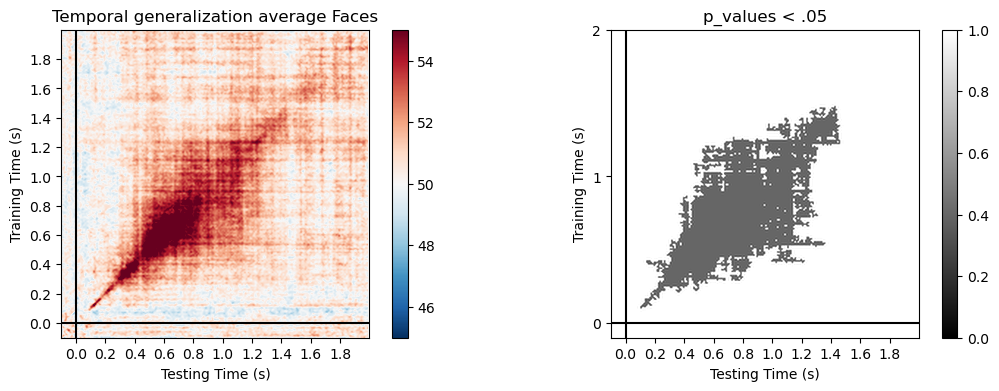

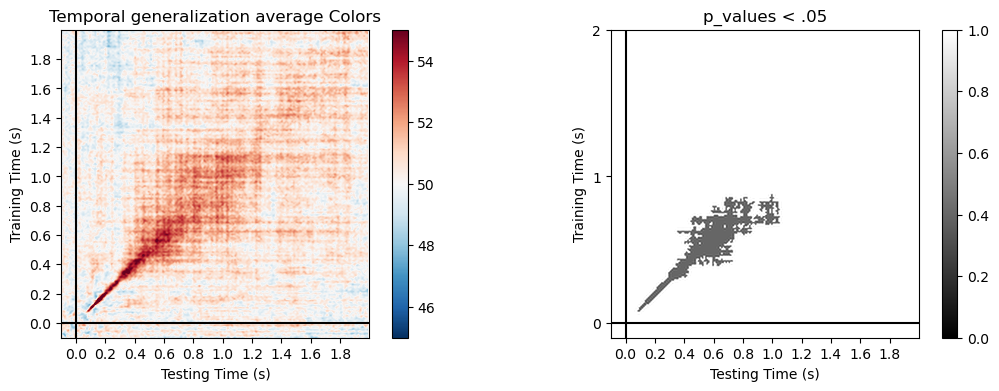

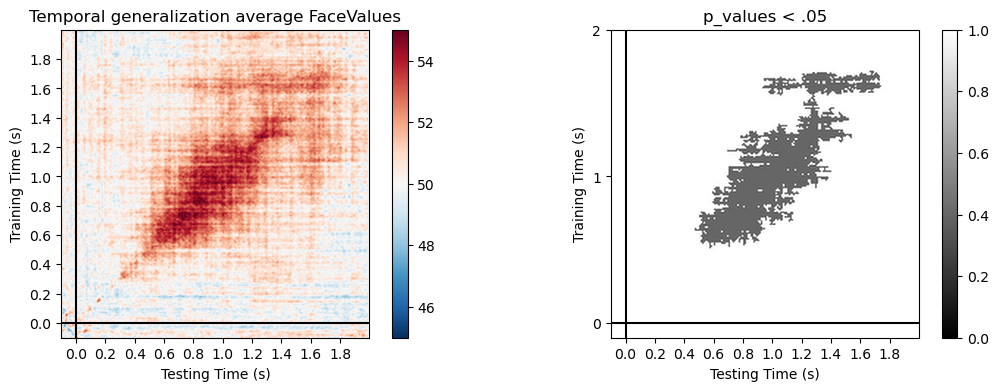

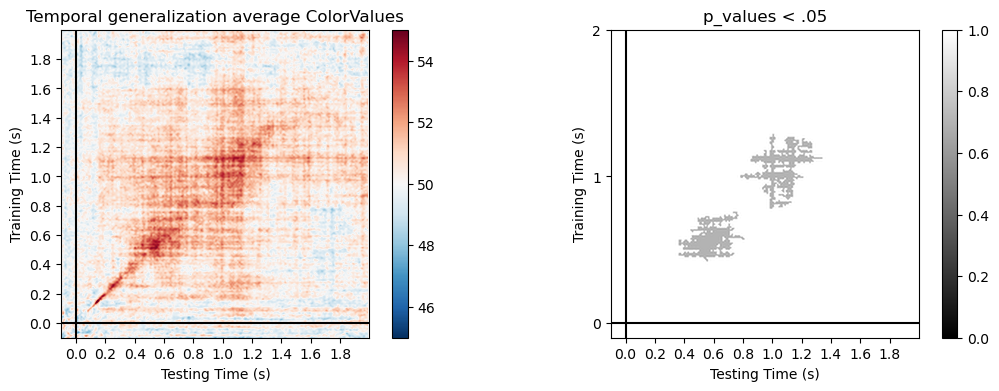

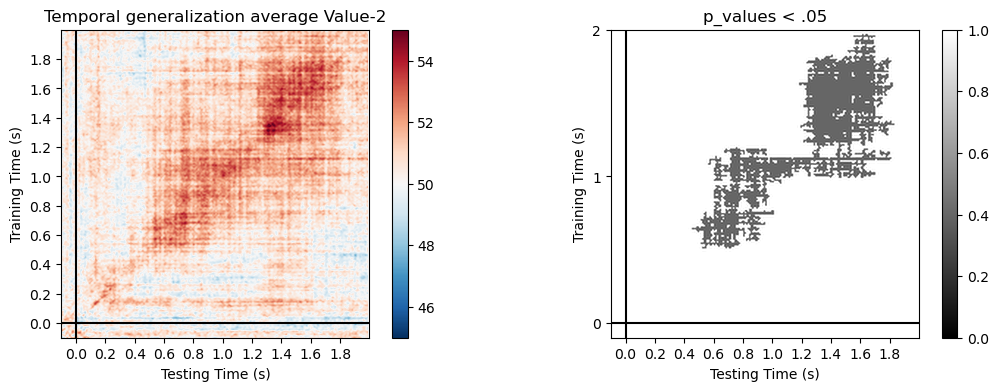

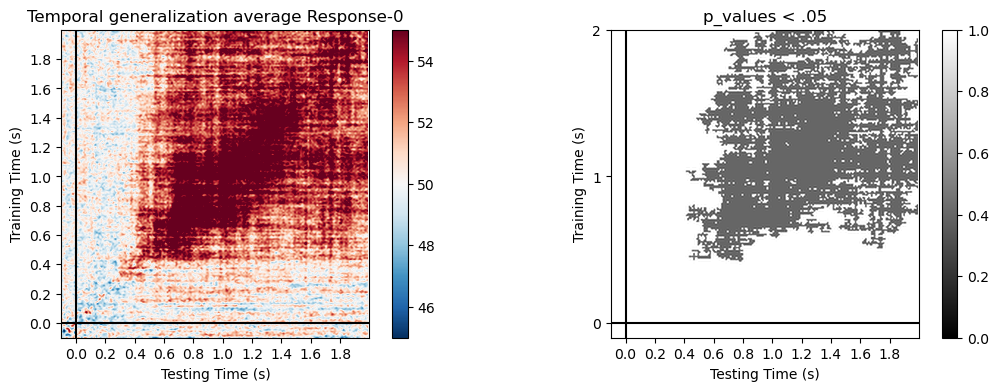

In [7]:
temp_Gen_Plot_average('Faces','binary',(-.2,2))
temp_Gen_Plot_average('Colors','binary',(-.2,2))
temp_Gen_Plot_average('FaceValues','binary',(-.2,2))
temp_Gen_Plot_average('ColorValues','binary',(-.2,2))
temp_Gen_Plot_average('Value-2','binary',(-.2,2))
temp_Gen_Plot_average('Response-0','binary',(-.2,2))